# Recommendation Module

###
---

### CLIP Model

#### Testing

In [ ]:
import os
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torch.nn.functional import cosine_similarity

In [ ]:
def load_clip_model(model_path):
    model = CLIPModel.from_pretrained(model_path, local_files_only=True)
    processor = CLIPProcessor.from_pretrained(model_path, local_files_only=True)
    return model, processor

def get_text_embedding(model, processor, text):
    inputs = processor(text=[text], return_tensors="pt", padding=True)
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    
    return text_features

def get_image_embedding(model, processor, image_path):
    image = Image.open(image_path)
    # image = image.resize((224, 224))
    inputs = processor(images=image, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    
    return image_features


def calculate_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1, embedding2).item()



   

In [ ]:
model_path = "../CLIP" 
model, processor = load_clip_model(model_path)

In [ ]:
folder_path = "../data/Trend Analysis/pinterest"

image_embeddings = {}
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith('.png'):
            test = os.path.join(root, file)
            image_embeddings[file] = get_image_embedding(model,processor,os.path.join(root, file))


In [ ]:
text = "stylish Belt"
text_embedding = get_text_embedding(model,processor,text)

In [ ]:
for img in image_embeddings:
    similarity = calculate_similarity(image_embeddings[img], text_embedding)
    print(img,similarity,end="\n----------\n")

#### Final Function 

In [ ]:
import os
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torch.nn.functional import cosine_similarity

In [ ]:
def load_clip_model(model_path):
    model = CLIPModel.from_pretrained(model_path, local_files_only=True)
    processor = CLIPProcessor.from_pretrained(model_path, local_files_only=True)
    return model, processor

def get_text_embedding(model, processor, text):
    inputs = processor(text=[text], return_tensors="pt", padding=True)
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    
    return text_features

def get_image_embedding(model, processor, image_path):
    image = Image.open(image_path)
    # image = image.resize((224, 224))
    inputs = processor(images=image, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    
    return image_features


def calculate_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1, embedding2).item()



model_path = "../CLIP" 
embedding_model, embedding_processor = load_clip_model(model_path)
   

###
---

### Purchase History Recommendation

#### Initializing Purchase History

In [ ]:
import os 
from PIL import Image
from tqdm import tqdm
import pandas as pd
from dotenv import load_dotenv

load_dotenv()

In [ ]:
image = Image.open("../data/Recommendation/purchase_data/image.png")

#### Generating Complimentary Description

In [ ]:
import pandas as pd          
import PIL.Image
import google.generativeai as genai     

In [ ]:
GOOGLE_API_KEY=os.getenv('API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)
llm_model = genai.GenerativeModel('models/gemini-1.5-pro-latest')

In [ ]:
# SUGGEST_ITEM_PROMPT = """ 
# Analyze the following image of a fashion product:

# Suggest 2 complementary fashion items that would pair well with this product, considering factors such as color coordination, style consistency, occasion appropriateness, and seasonal relevance.

# Format the response as follows, using '#' as a delimiter. Do not provide any descriptions or explanations, only the names of the items:

# #Complementary Item 1
# #Complementary Item 2
# """


SUGGEST_ITEM_PROMPT = """ 
Analyze the following image of a fashion product:

Suggest 2 complementary fashion items that would pair well with this product, considering factors such as color coordination, style consistency, occasion appropriateness, and seasonal relevance.

Format the response as follows, using '#' as a delimiter:

#Complementary Item 1
#Complementary Item 2
"""

In [ ]:

response = llm_model.generate_content([SUGGEST_ITEM_PROMPT, image], stream=False)


In [ ]:
print(response.text)

In [ ]:
suggestions = (list(filter(lambda x: x != "" and x!= '<Search Queries:>',map(str.strip,response.text.split("#")))))

#### Generating Vector Embeddings

In [ ]:
folder_path = "../data/Recommendation/available_stocks"

image_embeddings = {}
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith('.png'):
            print(file)
            image_embeddings[file] = get_image_embedding(model,processor,os.path.join(root, file))


In [ ]:
text_embd = get_text_embedding(model,processor,suggestions[0])

#### Retrieving Top 5 Recommendation

In [ ]:
search = []
for img in image_embeddings:
    similarity = calculate_similarity(image_embeddings[img], text_embd)
    search.append((similarity,img))

In [ ]:
search.sort(reverse=True)

In [ ]:
search[:5]

In [ ]:
suggestions[0]

#### Final Function

##### Importing Libraries

In [ ]:
import os 
from time import sleep
from PIL import Image
from tqdm import tqdm
import pandas as pd
from dotenv import load_dotenv


import torch
from transformers import CLIPProcessor, CLIPModel
from torch.nn.functional import cosine_similarity


import google.generativeai as genai     


import matplotlib.pyplot as plt
from IPython.display import display


load_dotenv()

##### Required Functions

In [ ]:
def load_clip_model(model_path:str)-> tuple[CLIPModel,CLIPProcessor]:
    model = CLIPModel.from_pretrained(model_path, local_files_only=True)
    processor = CLIPProcessor.from_pretrained(model_path, local_files_only=True)
    return model, processor


def get_text_embedding(model:CLIPModel, processor:CLIPProcessor, text:str)->torch.Tensor:
    inputs = processor(text=[text], return_tensors="pt", padding=True)
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features


def get_image_embedding(model:CLIPModel, processor:CLIPProcessor, image_path:str)->torch.Tensor:
    image = Image.open(image_path)
    # image = image.resize((224, 224))
    inputs = processor(images=image, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    
    return image_features


def calculate_similarity(embedding1:torch.Tensor, embedding2:torch.Tensor)->float:
    return cosine_similarity(embedding1, embedding2).item()


def generate_suggestion_based_on_purchase_history(image:str,model:genai.GenerativeModel)->list[str]:

    SUGGEST_ITEM_PROMPT = """ 
    Analyze the following image of a fashion product:

    Suggest 2 complementary fashion items that would pair well with this product, considering factors such as color coordination, style consistency, occasion appropriateness, and seasonal relevance.

    Format the response as follows, using '#' as a delimiter:

    #Complementary Item 1
    #Complementary Item 2
    """

    sleep(5)
    try:
        response = model.generate_content([SUGGEST_ITEM_PROMPT, image], stream=False)
    except:
        return []
    

    if("text:" not in str(response.candidates)): return []

    return(list(filter(lambda x: x != "" and x!= '<Search Queries:>',map(str.strip,response.text.split("#")))))


def generate_image_vector_embeddings(folder_path:str,model:CLIPModel,processor:CLIPProcessor)->dict[str,torch.Tensor]:
    image_embeddings = {}
    for root, dirs, files in tqdm(os.walk(folder_path)):
        for file in files:
            if file.lower().endswith('.png'):
                image_embeddings[file] = get_image_embedding(model,processor,os.path.join(root, file))

    return image_embeddings


def text_image_retriever(text:str,image_embeddings:dict[str,torch.Tensor],model:CLIPModel,processor:CLIPProcessor,top_k:int=5)->list[list[int,str]]:
    
    text_embd = get_text_embedding(model,processor,text)
    search = []
    for img in image_embeddings:
        similarity = calculate_similarity(image_embeddings[img], text_embd)
        search.append((similarity,img))
    
    search.sort(reverse=True)

    return search[:top_k]


   

##### Initial Setup

In [ ]:
model_path = "../CLIP" 
embedding_model, embedding_processor = load_clip_model(model_path)

avaliable_stock_path = "../data/Recommendation/available_stocks"

In [ ]:
GOOGLE_API_KEY=os.getenv('API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)
llm_model = genai.GenerativeModel('models/gemini-1.5-pro-latest')

image_embeddings = generate_image_vector_embeddings(avaliable_stock_path,embedding_model,embedding_processor)

##### Pipeline

In [ ]:
def recommend_fashion_items_for_purchase_history(purchased_item_image:Image,image_embeddings:dict[str,torch.Tensor],llm_model:genai.GenerativeModel,embedding_model:CLIPModel,embedding_processor:CLIPProcessor) -> list[str]:

    fashion_item_suggestion = generate_suggestion_based_on_purchase_history(purchased_item_image,llm_model)
    if(len(fashion_item_suggestion)==0): return {-1:"Something Went Wrong"}

    recommendations = []
    for suggested_item_description in fashion_item_suggestion:
        suggestions = text_image_retriever(suggested_item_description,image_embeddings,embedding_model,embedding_processor,top_k=3)
        recommendations.extend([i[1] for i in suggestions if i[1] not in recommendations])
    
    return recommendations

    

##### Sample Use Case

In [ ]:
def display_images_in_jupyter(list_images:list[Image], max_images:int=5, figsize:tuple[int,int]=(7, 5))->None:
    # Limit the number of images to display
    list_images = list_images[:max_images]
    
    # Calculate the number of rows and columns for the subplot grid
    n_images = len(list_images)
    n_cols = min(3, n_images)  # Max 3 columns
    n_rows = (n_images - 1) // n_cols + 1
    
    # Create a new figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle("Recommendations", fontsize=16)
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten() if n_images > 1 else [axes]
    
    for i, img in enumerate(list_images):
 
        # Display the image
        axes[i].imshow(img)
        axes[i].set_title(f"Image\n{img.format}, {img.size}, {img.mode}")
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    display(fig)
    plt.close(fig)

In [108]:
purchased_item_image = Image.open("../data/Recommendation/purchase_data/image.png")


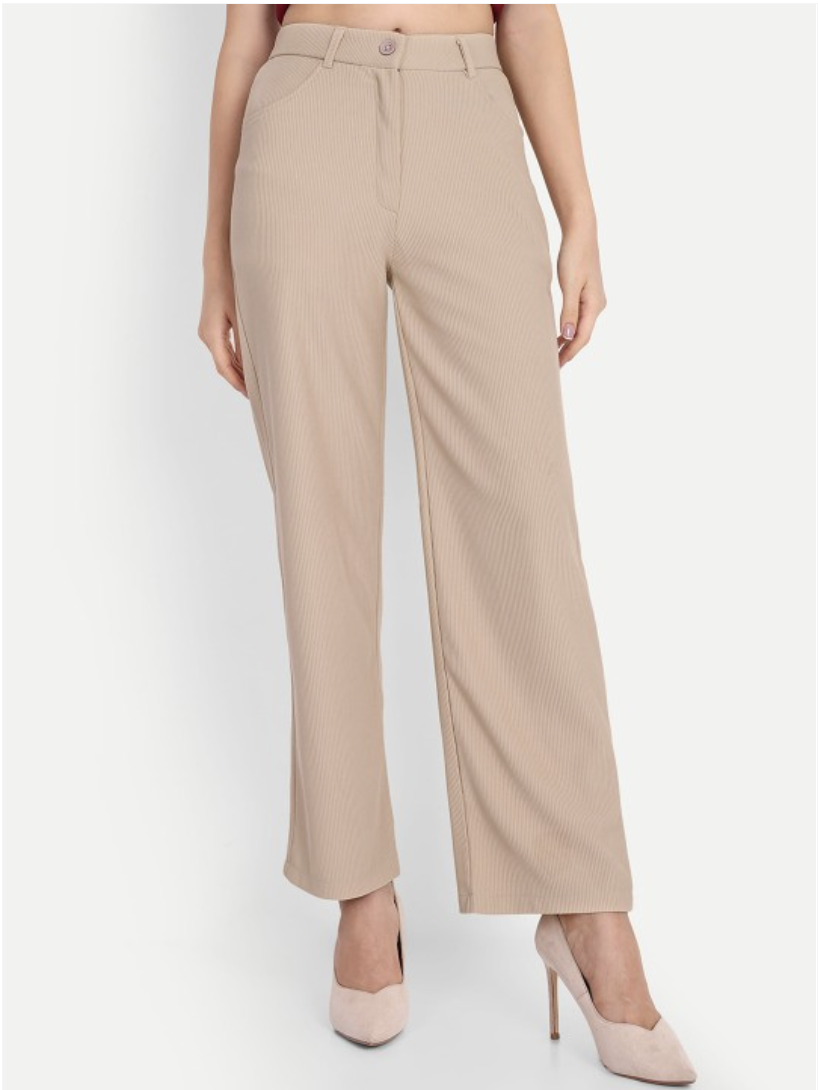

In [111]:
purchased_item_image

In [109]:
recommendations = recommend_fashion_items_for_purchase_history(purchased_item_image,image_embeddings,llm_model,embedding_model,embedding_processor)

In [110]:
products = []
for image_id in recommendations:
    products.append(Image.open(f"{avaliable_stock_path}/{image_id}"))

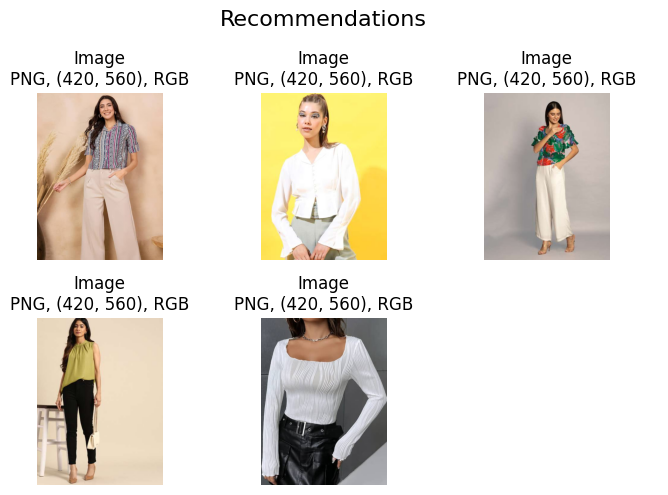

In [112]:
display_images_in_jupyter(products)

###
---

### Description Based Recommendation

#### Final Function

##### Importing Libraries

In [ ]:
import os 
from time import sleep
from PIL import Image
from tqdm import tqdm
import pandas as pd
from dotenv import load_dotenv


import torch
from transformers import CLIPProcessor, CLIPModel
from torch.nn.functional import cosine_similarity


import google.generativeai as genai     


import matplotlib.pyplot as plt
from IPython.display import display


load_dotenv()

##### Required Functions

In [ ]:
def load_clip_model(model_path:str)-> tuple[CLIPModel,CLIPProcessor]:
    model = CLIPModel.from_pretrained(model_path, local_files_only=True)
    processor = CLIPProcessor.from_pretrained(model_path, local_files_only=True)
    return model, processor


def get_text_embedding(model:CLIPModel, processor:CLIPProcessor, text:str)->torch.Tensor:
    inputs = processor(text=[text], return_tensors="pt", padding=True)
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features


def get_image_embedding(model:CLIPModel, processor:CLIPProcessor, image_path:str)->torch.Tensor:
    image = Image.open(image_path)
    # image = image.resize((224, 224))
    inputs = processor(images=image, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    
    return image_features


def calculate_similarity(embedding1:torch.Tensor, embedding2:torch.Tensor)->float:
    return cosine_similarity(embedding1, embedding2).item()


def generate_suggestion_based_on_purchase_history(image:str,model:genai.GenerativeModel)->list[str]:

    SUGGEST_ITEM_PROMPT = """ 
    Analyze the following image of a fashion product:

    Suggest 2 complementary fashion items that would pair well with this product, considering factors such as color coordination, style consistency, occasion appropriateness, and seasonal relevance.

    Format the response as follows, using '#' as a delimiter:

    #Complementary Item 1
    #Complementary Item 2
    """

    sleep(5)
    try:
        response = model.generate_content([SUGGEST_ITEM_PROMPT, image], stream=False)
    except:
        return []
    

    if("text:" not in str(response.candidates)): return []

    return(list(filter(lambda x: x != "" and x!= '<Search Queries:>',map(str.strip,response.text.split("#")))))


def generate_image_vector_embeddings(folder_path:str,model:CLIPModel,processor:CLIPProcessor)->dict[str,torch.Tensor]:
    image_embeddings = {}
    for root, dirs, files in tqdm(os.walk(folder_path)):
        for file in files:
            if file.lower().endswith('.png'):
                image_embeddings[file] = get_image_embedding(model,processor,os.path.join(root, file))

    return image_embeddings


def text_image_retriever(text:str,image_embeddings:dict[str,torch.Tensor],model:CLIPModel,processor:CLIPProcessor,top_k:int=5)->list[list[int,str]]:
    
    text_embd = get_text_embedding(model,processor,text)
    search = []
    for img in image_embeddings:
        similarity = calculate_similarity(image_embeddings[img], text_embd)
        search.append((similarity,img))
    
    search.sort(reverse=True)

    return search[:top_k]


   

##### Initial Setup

In [ ]:
model_path = "../CLIP" 
embedding_model, embedding_processor = load_clip_model(model_path)

avaliable_stock_path = "../data/Recommendation/available_stocks"

In [ ]:
GOOGLE_API_KEY=os.getenv('API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)
llm_model = genai.GenerativeModel('models/gemini-1.5-pro-latest')

image_embeddings = generate_image_vector_embeddings(avaliable_stock_path,embedding_model,embedding_processor)

##### Pipeline

In [ ]:
def recommend_fashion_items_for_text_description(text_description:str,image_embeddings:dict[str,torch.Tensor],embedding_model:CLIPModel,embedding_processor:CLIPProcessor) -> list[str]:

    suggestions = text_image_retriever(text_description,image_embeddings,embedding_model,embedding_processor,top_k=3)
    suggestions = [i[1] for i in suggestions]

    return suggestions

    

##### Sample Use Case

In [ ]:
def display_images_in_jupyter(list_images:list[Image], max_images:int=5, figsize:tuple[int,int]=(7, 5))->None:
    # Limit the number of images to display
    list_images = list_images[:max_images]
    
    # Calculate the number of rows and columns for the subplot grid
    n_images = len(list_images)
    n_cols = min(3, n_images)  # Max 3 columns
    n_rows = (n_images - 1) // n_cols + 1
    
    # Create a new figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle("Recommendations", fontsize=16)
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten() if n_images > 1 else [axes]
    
    for i, img in enumerate(list_images):
 
        # Display the image
        axes[i].imshow(img)
        axes[i].set_title(f"Image\n{img.format}, {img.size}, {img.mode}")
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    display(fig)
    plt.close(fig)

In [121]:
text = "i am looking for some floral dresses"


In [122]:
recommendations = recommend_fashion_items_for_text_description(text,image_embeddings,embedding_model,embedding_processor)

In [123]:
products = []
for image_id in recommendations:
    products.append(Image.open(f"{avaliable_stock_path}/{image_id}"))

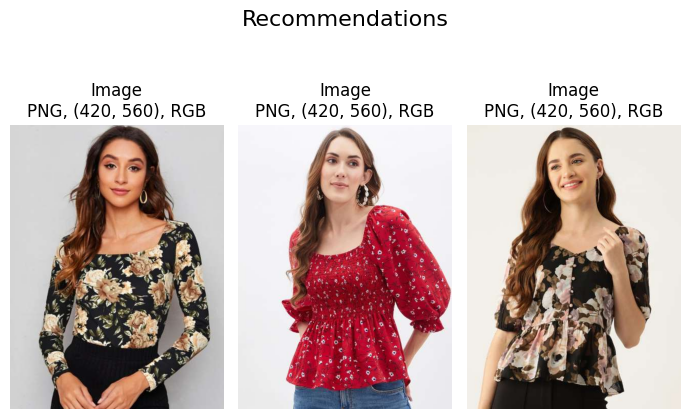

In [124]:
display_images_in_jupyter(products)

###
---

### Photo Based Recommendation

#### Final Function

##### Importing Libraries

In [ ]:
import os 
from time import sleep
from PIL import Image
from tqdm import tqdm
import pandas as pd
from dotenv import load_dotenv


import torch
from transformers import CLIPProcessor, CLIPModel
from torch.nn.functional import cosine_similarity


import google.generativeai as genai     


import matplotlib.pyplot as plt
from IPython.display import display


load_dotenv()

##### Required Functions

In [ ]:
def load_clip_model(model_path:str)-> tuple[CLIPModel,CLIPProcessor]:
    model = CLIPModel.from_pretrained(model_path, local_files_only=True)
    processor = CLIPProcessor.from_pretrained(model_path, local_files_only=True)
    return model, processor


def get_text_embedding(model:CLIPModel, processor:CLIPProcessor, text:str)->torch.Tensor:
    inputs = processor(text=[text], return_tensors="pt", padding=True)
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features


def get_image_embedding(model:CLIPModel, processor:CLIPProcessor, image_path:str="",image:Image=None)->torch.Tensor:
    
    if(image == None):
        image = Image.open(image_path)
    # image = image.resize((224, 224))
    inputs = processor(images=image, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    
    return image_features


def calculate_similarity(embedding1:torch.Tensor, embedding2:torch.Tensor)->float:
    return cosine_similarity(embedding1, embedding2).item()


def generate_suggestion_based_on_purchase_history(image:str,model:genai.GenerativeModel)->list[str]:

    SUGGEST_ITEM_PROMPT = """ 
    Analyze the following image of a fashion product:

    Suggest 2 complementary fashion items that would pair well with this product, considering factors such as color coordination, style consistency, occasion appropriateness, and seasonal relevance.

    Format the response as follows, using '#' as a delimiter:

    #Complementary Item 1
    #Complementary Item 2
    """

    sleep(5)
    try:
        response = model.generate_content([SUGGEST_ITEM_PROMPT, image], stream=False)
    except:
        return []
    

    if("text:" not in str(response.candidates)): return []

    return(list(filter(lambda x: x != "" and x!= '<Search Queries:>',map(str.strip,response.text.split("#")))))


def generate_image_vector_embeddings(folder_path:str,model:CLIPModel,processor:CLIPProcessor)->dict[str,torch.Tensor]:
    image_embeddings = {}
    for root, dirs, files in tqdm(os.walk(folder_path)):
        for file in files:
            if file.lower().endswith('.png'):
                image_embeddings[file] = get_image_embedding(model,processor,os.path.join(root, file))

    return image_embeddings


def image_image_retriever(search_image:Image,image_embeddings:dict[str,torch.Tensor],model:CLIPModel,processor:CLIPProcessor,top_k:int=5)->list[list[int,str]]:
    
    image_embd = get_image_embedding(model,processor,image=search_image)
    search = []
    for img in image_embeddings:
        similarity = calculate_similarity(image_embeddings[img], image_embd)
        search.append((similarity,img))
    
    search.sort(reverse=True)

    return search[:top_k]


   

##### Initial Setup

In [ ]:
model_path = "../CLIP" 
embedding_model, embedding_processor = load_clip_model(model_path)

avaliable_stock_path = "../data/Recommendation/available_stocks"

In [ ]:
GOOGLE_API_KEY=os.getenv('API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)
llm_model = genai.GenerativeModel('models/gemini-1.5-pro-latest')

image_embeddings = generate_image_vector_embeddings(avaliable_stock_path,embedding_model,embedding_processor)

##### Pipeline

In [ ]:
def recommend_fashion_items_for_image(item_image:Image,image_embeddings:dict[str,torch.Tensor],embedding_model:CLIPModel,embedding_processor:CLIPProcessor) -> list[str]:

    suggestions = image_image_retriever(item_image,image_embeddings,embedding_model,embedding_processor,top_k=3)
    suggestions = [i[1] for i in suggestions ]

    return suggestions

    

##### Sample Use Case

In [ ]:
def display_images_in_jupyter(list_images:list[Image], max_images:int=5, figsize:tuple[int,int]=(7, 5))->None:
    # Limit the number of images to display
    list_images = list_images[:max_images]
    
    # Calculate the number of rows and columns for the subplot grid
    n_images = len(list_images)
    n_cols = min(3, n_images)  # Max 3 columns
    n_rows = (n_images - 1) // n_cols + 1
    
    # Create a new figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle("Recommendations", fontsize=16)
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten() if n_images > 1 else [axes]
    
    for i, img in enumerate(list_images):
 
        # Display the image
        axes[i].imshow(img)
        axes[i].set_title(f"Image\n{img.format}, {img.size}, {img.mode}")
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    display(fig)
    plt.close(fig)

In [125]:
search_item_image = Image.open("../data/Recommendation/purchase_data/image.png")


In [126]:
recommendations = recommend_fashion_items_for_image(search_item_image,image_embeddings,embedding_model,embedding_processor)

In [127]:
products = []
for image_id in recommendations:
    products.append(Image.open(f"{avaliable_stock_path}/{image_id}"))

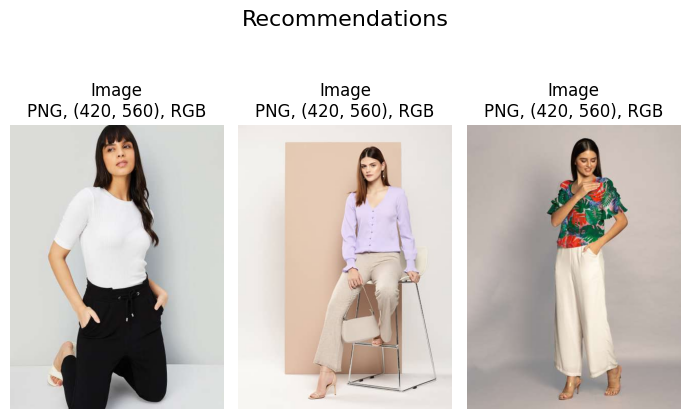

In [128]:
display_images_in_jupyter(products)

###
---